In [1]:
import numpy as np
import pandas as pd
import glob
import imageio
import cv2
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import tensorflow as tf

## Load and check data

In [2]:
data_info = pd.read_csv("./set-lipstick-original/list.csv")
data_info.head()

filename  width  height class  xmin  ymin  xmax  ymax  \
0  image00000001.jpg   1280     720  Lips   661   394   776   444   
1  image00000002.jpg   1280     720  Lips   557   336   682   392   
2  image00000003.jpg   1280     720  Lips   553   369   684   427   
3  image00000004.jpg   1280     720  Lips   555   351   681   408   
4  image00000005.jpg   1280     720  Lips   555   351   680   407   

               mask  
0  mask00000001.png  
1  mask00000002.png  
2  mask00000003.png  
3  mask00000004.png  
4  mask00000005.png

In [3]:
data_info.describe()

width        height          xmin          ymin         xmax  \
count  28594.0  28594.000000  28594.000000  28594.000000  28594.00000   
mean    1280.0    718.663881    598.519445    301.300273    704.45632   
std        0.0      7.638207     84.979569     84.473834     88.29236   
min     1280.0    675.000000    170.000000     22.000000    280.00000   
25%     1280.0    720.000000    578.000000    242.000000    672.00000   
50%     1280.0    720.000000    601.000000    294.000000    691.00000   
75%     1280.0    720.000000    630.000000    356.000000    724.00000   
max     1280.0    720.000000   1036.000000    577.000000   1082.00000   

               ymax  
count  28594.000000  
mean     362.676016  
std       96.020078  
min       98.000000  
25%      295.000000  
50%      356.000000  
75%      419.000000  
max      650.000000

In [4]:
data_info.loc[data_info['height'] < 720, :]

filename  width  height class  xmin  ymin  xmax  ymax  \
12485  image00012486.jpg   1280     675  Lips   492   318   915   530   
12486  image00012487.jpg   1280     675  Lips   513   321   936   530   
12487  image00012488.jpg   1280     675  Lips   502   318   920   541   
12488  image00012489.jpg   1280     675  Lips   468   185   854   382   
12489  image00012490.jpg   1280     675  Lips   410   202   804   475   
...                  ...    ...     ...   ...   ...   ...   ...   ...   
14379  image00014380.jpg   1280     675  Lips   745   363   842   414   
14380  image00014381.jpg   1280     675  Lips   422   299   480   328   
14381  image00014382.jpg   1280     675  Lips   811   431  1015   533   
14382  image00014383.jpg   1280     675  Lips   420   293   479   327   
14383  image00014384.jpg   1280     675  Lips   450   289   524   341   

                   mask  
12485  mask00012486.png  
12486  mask00012487.png  
12487  mask00012488.png  
12488  mask00012489.png  
12489  mask00012490.png  
...                 ...  
14379  mask00014380.png  
14380  mask00014381.png  
14381  mask00014382.png  
14382  mask00014383.png  
14383  mask00014384.png  

[849 rows x 9 columns]

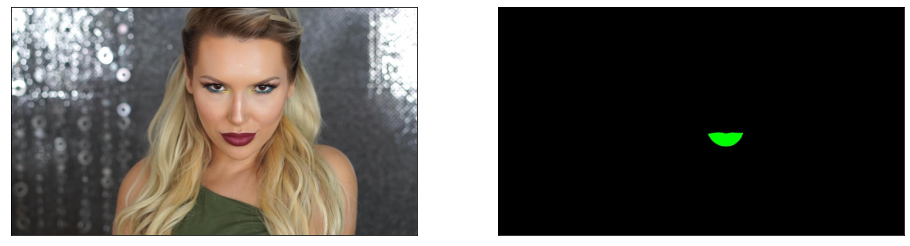

In [5]:
plt.figure(figsize=(16,10))
plt.subplot(121)
plt.imshow(imageio.imread("./set-lipstick-original/720p/image00000001.jpg"))
plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(imageio.imread("./set-lipstick-original/mask/mask00000001.png"))
plt.xticks([]), plt.yticks([])
plt.show()

In [6]:
imageio.imread("./set-lipstick-original/720p/image00000001.jpg").shape, imageio.imread("./set-lipstick-original/mask/mask00000001.png").shape

((720, 1280, 3), (720, 1280, 3))

In [7]:
list_images = sorted([i for i in Path("./set-lipstick-original/720p").iterdir()])
list_masks = sorted([i for i in Path("./set-lipstick-original/mask").iterdir()])
len(list_images), len(list_masks)

(28594, 28540)

In [8]:
# Use data withou mask for test
data_test = data_info.loc[~data_info['mask'].isin([i.name for i in list_masks])]
data_test.reset_index(drop=True, inplace=True)

# Remove data without mask from train dataset
data_info = data_info.loc[data_info['mask'].isin([i.name for i in list_masks])]
data_info.reset_index(drop=True, inplace=True)

data_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28540 non-null  object
 1   width     28540 non-null  int64 
 2   height    28540 non-null  int64 
 3   class     28540 non-null  object
 4   xmin      28540 non-null  int64 
 5   ymin      28540 non-null  int64 
 6   xmax      28540 non-null  int64 
 7   ymax      28540 non-null  int64 
 8   mask      28540 non-null  object
dtypes: int64(6), object(3)
memory usage: 2.0+ MB


## Build model

In [9]:
# U-net architecture
x = tf.keras.layers.Input((80, 160, 3))

out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
out = tf.keras.layers.MaxPool2D((2, 2))(out1)

out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
out = tf.keras.layers.MaxPool2D((2, 2))(out2)

out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
out = tf.keras.layers.MaxPool2D((2, 2))(out3)

out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
out = tf.keras.layers.MaxPool2D((2, 2))(out4)

out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
out = tf.concat([out4, out], axis=3)

out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
out = tf.concat([out3, out], axis=3)

out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
out = tf.concat([out2, out], axis=3)

out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
out = tf.concat([out1, out], axis=3)

out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

model = tf.keras.Model(inputs=x, outputs=out)

In [13]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 160, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 80, 160, 64)  1792        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 80, 160, 64)  36928       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 40, 80, 64)   0           ['conv2d_1[0][0]']           

In [15]:
X_data = []
with tf.device('/CPU:0'):
    for image_path in glob.glob("./set-lipstick-original/720p/*.jpg"):
        # leave only pics with mask
        if np.any(np.isin(data_info['filename'], image_path[-17:])):
            img = imageio.imread(image_path).astype(np.float32) / 255.
            X_data.append(tf.image.resize(img, size=(80, 160)))
    print(np.array(X_data).shape)

(28540, 80, 160, 3)


In [16]:
y_data = []
with tf.device('/CPU:0'):
    for image_path in glob.glob("./set-lipstick-original/mask/*.png"):
        img = imageio.imread(image_path).astype(np.float32) / 255.
        # Masks have 2 and 3 dimensions...
        if imageio.imread(image_path).ndim == 3:
            y_data.append(tf.image.resize(tf.reduce_mean(img, axis=2, keepdims=True), size=(80, 160)))
        else:
            y_data.append(tf.image.resize(tf.expand_dims(img, axis=2), size=(80, 160)))
    print(np.array(y_data).shape)

(28540, 80, 160, 1)


In [17]:
# Network Parameters
NUM_EPOCHS = 10
BATCH_SIZE = 8
LEARNING_RATE = 3e-4

In [18]:
with tf.device('/CPU:0'):
    train_ds = tf.data.Dataset.from_tensor_slices((X_data, y_data))
    train_ds = train_ds.shuffle(buffer_size=np.array(X_data).shape[0])
    train_ds = train_ds.repeat(NUM_EPOCHS)
    train_ds = train_ds.batch(BATCH_SIZE)
print(train_ds)

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy()

<BatchDataset shapes: ((None, 80, 160, 3), (None, 80, 160, 1)), types: (tf.float32, tf.float32)>


0it [00:00, ?it/s]

[0] Loss: 0.7274712920188904


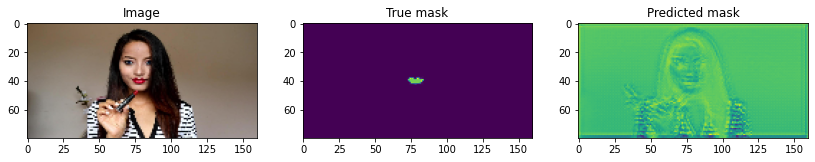

500it [03:10,  2.84it/s]

[500] Loss: 0.006425254512578249


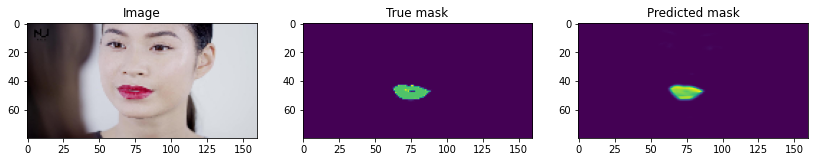

1000it [06:14,  2.81it/s]

[1000] Loss: 0.0022252167109400034


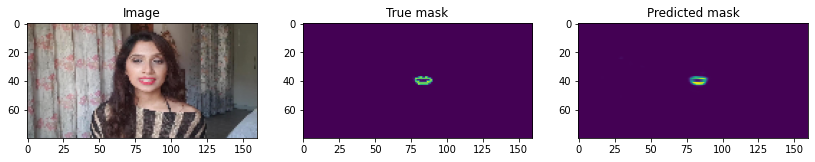

1500it [09:18,  2.82it/s]

[1500] Loss: 0.0017542289569973946


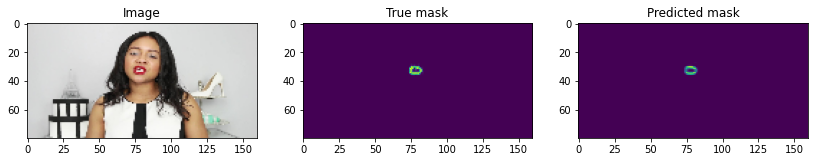

2000it [12:21,  2.81it/s]

[2000] Loss: 0.00263947038911283


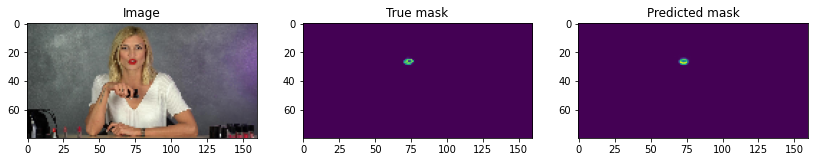

2500it [15:26,  2.83it/s]

[2500] Loss: 0.0020646359771490097


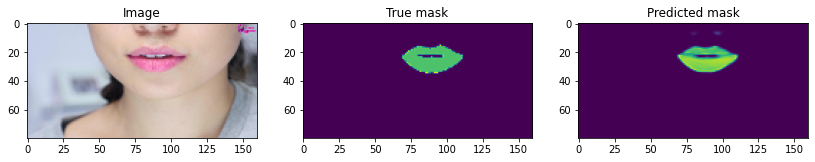

3000it [18:33,  2.77it/s]

[3000] Loss: 0.0026754499413073063


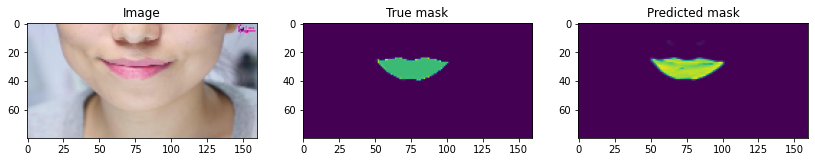

3500it [21:41,  2.71it/s]

[3500] Loss: 0.0018559977179393172


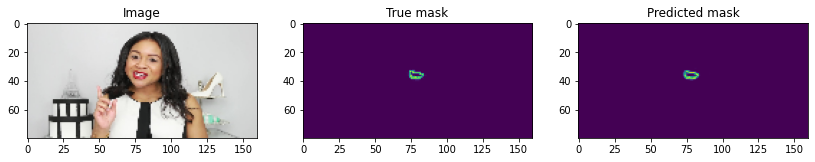

4000it [24:44,  2.79it/s]

[4000] Loss: 0.0024588853120803833


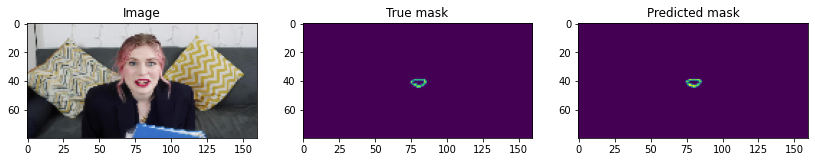

4500it [27:44,  2.84it/s]

[4500] Loss: 0.004476800095289946


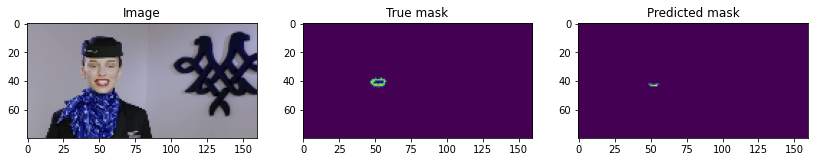

5000it [30:44,  2.87it/s]

[5000] Loss: 0.002882125787436962


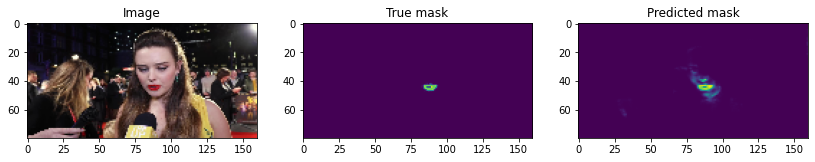

5500it [33:45,  2.86it/s]

[5500] Loss: 0.0042721983045339584


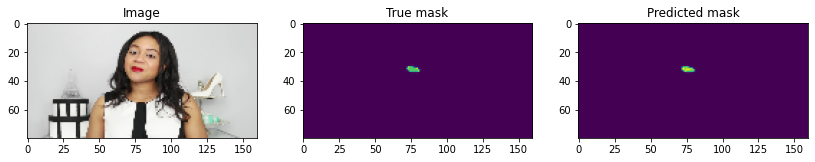

6000it [36:51,  2.85it/s]

[6000] Loss: 0.0069164251908659935


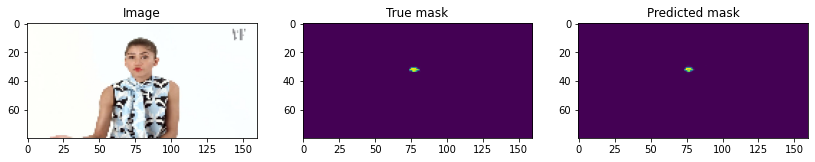

6500it [39:50,  2.86it/s]

[6500] Loss: 0.004268457181751728


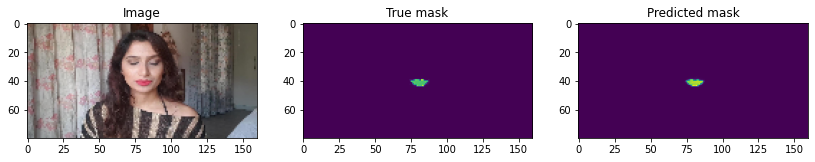

7000it [42:49,  2.87it/s]

[7000] Loss: 0.007541409693658352


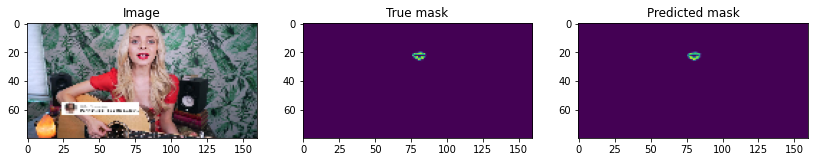

7500it [45:49,  2.85it/s]

[7500] Loss: 0.004280332941561937


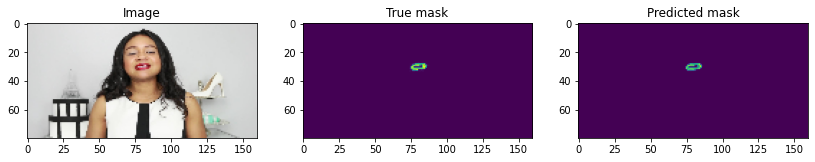

8000it [48:49,  2.80it/s]

[8000] Loss: 0.003631412982940674


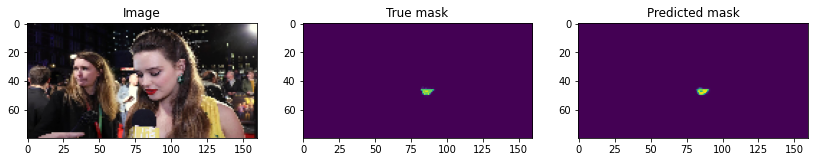

8500it [51:50,  2.84it/s]

[8500] Loss: 0.0021205053199082613


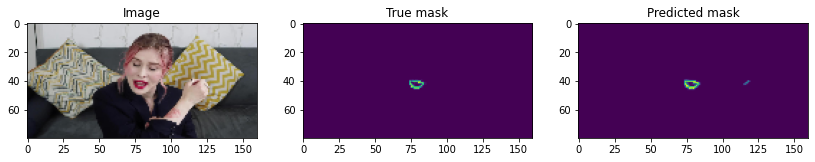

9000it [54:50,  2.88it/s]

[9000] Loss: 0.0027126818895339966


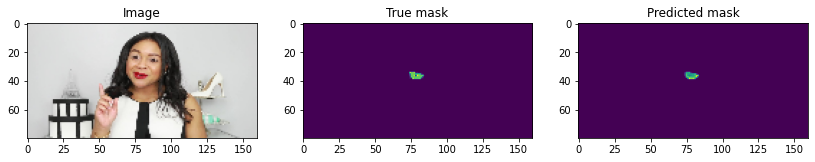

9500it [57:50,  2.85it/s]

[9500] Loss: 0.0025198478251695633


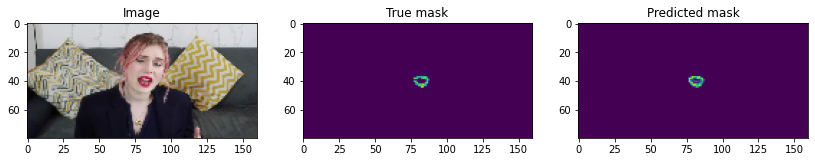

10000it [1:00:50,  2.82it/s]

[10000] Loss: 0.005074121989309788


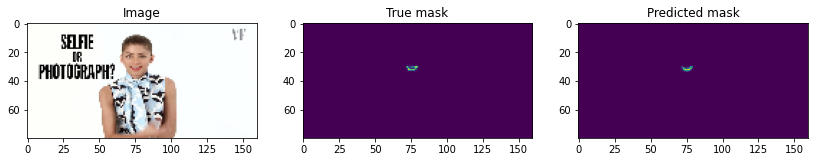

10500it [1:03:51,  2.86it/s]

[10500] Loss: 0.002775933826342225


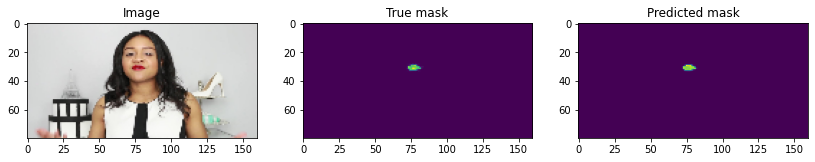

11000it [1:06:51,  2.87it/s]

[11000] Loss: 0.003652869490906596


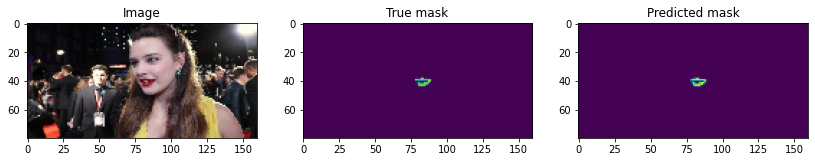

11500it [1:09:53,  2.84it/s]

[11500] Loss: 0.00267451792024076


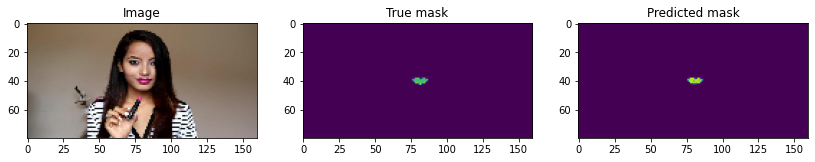

12000it [1:12:55,  2.88it/s]

[12000] Loss: 0.0030128834769129753


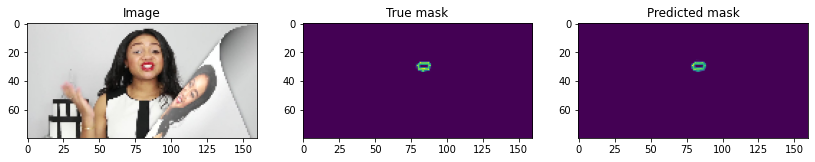

12500it [7:20:19,  2.80it/s]  

[12500] Loss: 0.005156089086085558


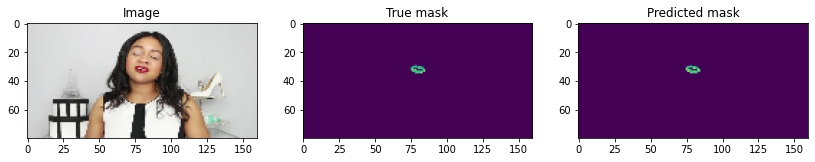

13000it [7:23:26,  2.80it/s]

[13000] Loss: 0.002683849073946476


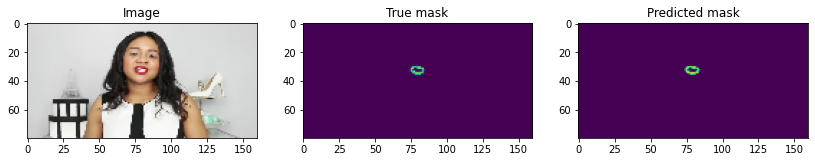

13500it [7:26:39,  2.71it/s]

[13500] Loss: 0.007418843451887369


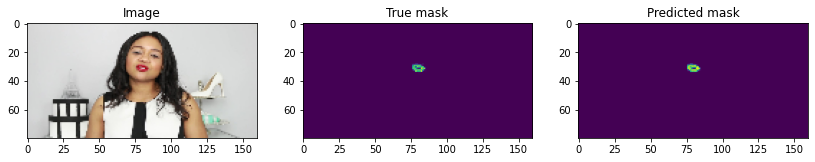

14000it [7:29:53,  2.66it/s]

[14000] Loss: 0.003642166266217828


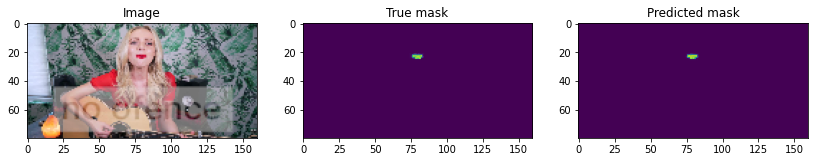

14500it [7:33:07,  2.70it/s]

[14500] Loss: 0.003136842045933008


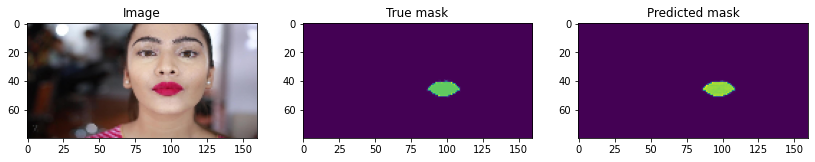

15000it [7:36:21,  2.69it/s]

[15000] Loss: 0.004486404825001955


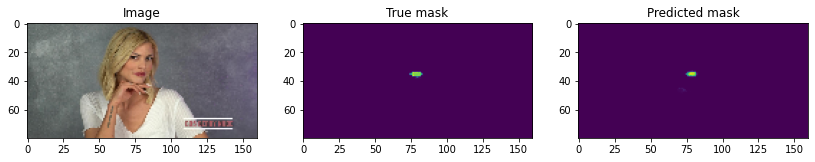

15500it [7:39:35,  2.70it/s]

[15500] Loss: 0.0026934670750051737


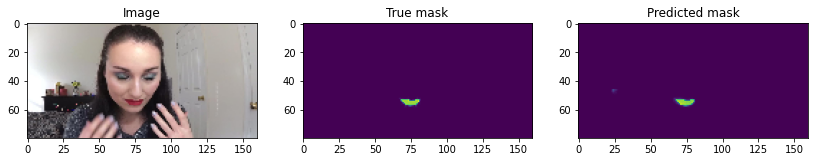

16000it [7:42:50,  2.69it/s]

[16000] Loss: 0.0028708085883408785


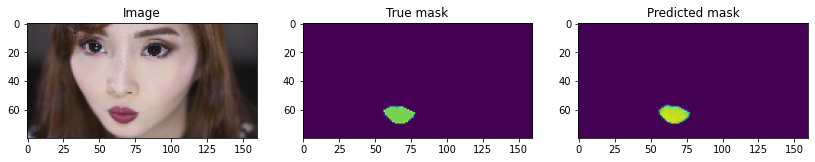

16500it [7:46:04,  2.70it/s]

[16500] Loss: 0.002027068519964814


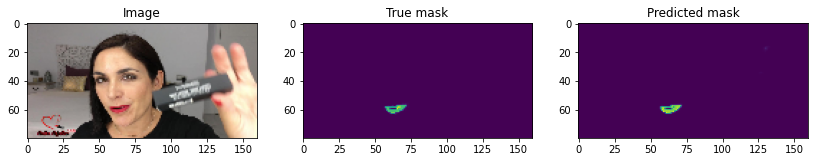

17000it [7:49:18,  2.70it/s]

[17000] Loss: 0.0023497764486819506


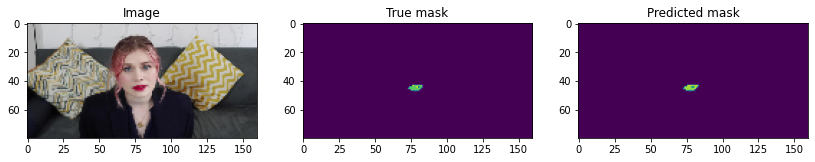

17500it [7:52:33,  2.68it/s]

[17500] Loss: 0.004879596643149853


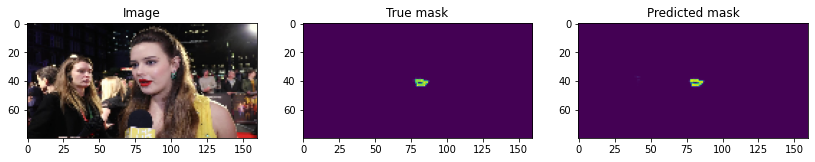

18000it [7:55:48,  2.69it/s]

[18000] Loss: 0.004278771113604307


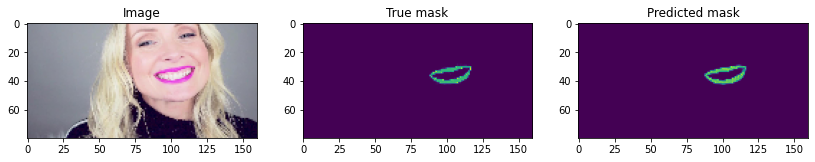

18500it [7:59:03,  2.69it/s]

[18500] Loss: 0.006458854768425226


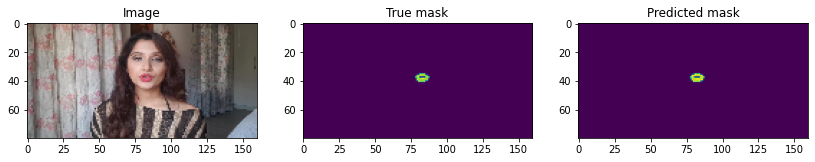

19000it [8:02:18,  2.67it/s]

[19000] Loss: 0.0024348674342036247


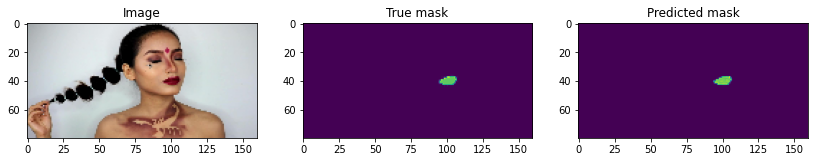

19500it [8:05:33,  2.69it/s]

[19500] Loss: 0.0028313947841525078


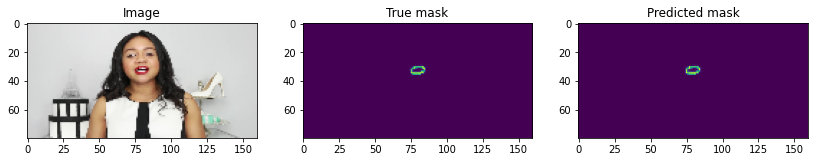

20000it [8:12:38,  1.10it/s]

[20000] Loss: 0.008728227578103542


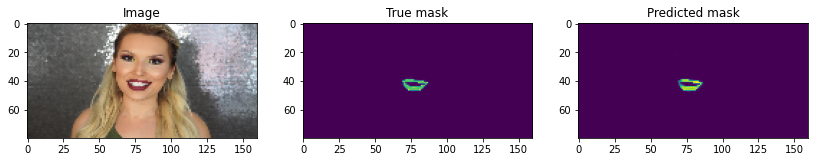

20500it [8:20:25,  1.05it/s]

[20500] Loss: 0.0021207802928984165


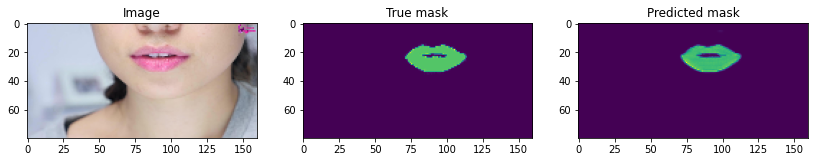

21000it [11:14:12,  2.94it/s]  

[21000] Loss: 0.0026182448491454124


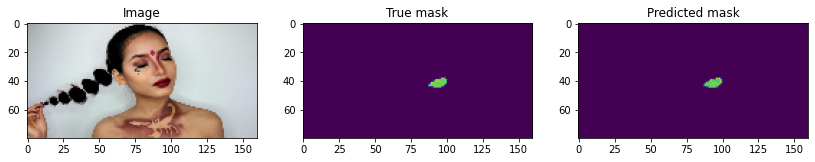

21500it [11:17:07,  2.92it/s]

[21500] Loss: 0.0016662514535710216


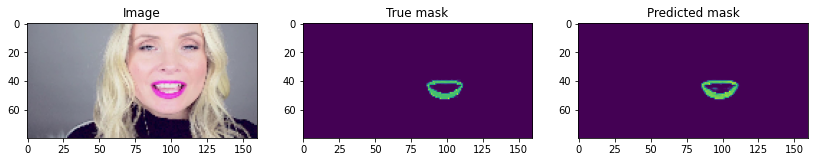

22000it [11:20:03,  2.91it/s]

[22000] Loss: 0.0037405192852020264


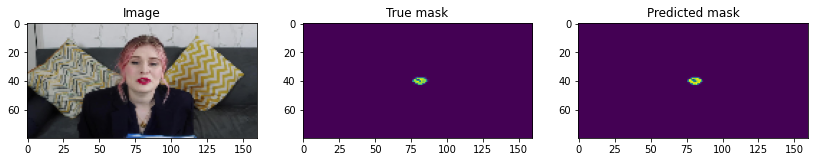

22500it [11:23:00,  2.87it/s]

[22500] Loss: 0.0035764502827078104


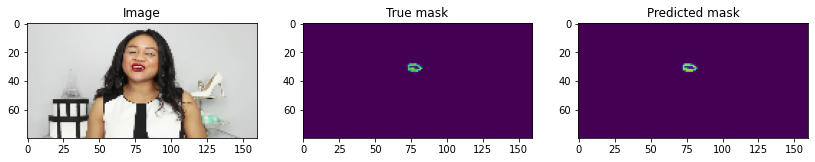

23000it [11:25:58,  2.87it/s]

[23000] Loss: 0.00549587607383728


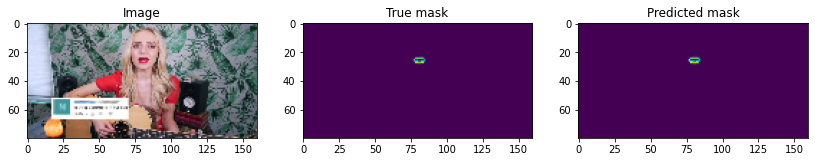

23500it [11:28:58,  2.82it/s]

[23500] Loss: 0.0027869141194969416


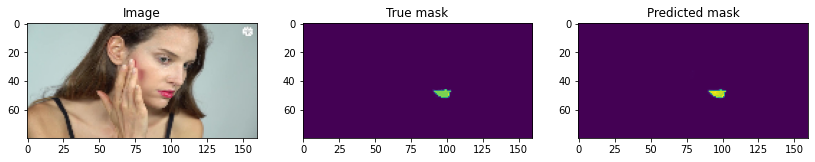

24000it [11:31:58,  2.86it/s]

[24000] Loss: 0.002826934214681387


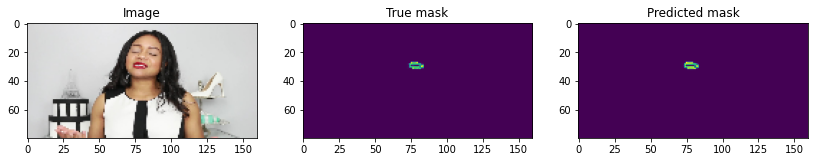

24500it [11:34:58,  2.86it/s]

[24500] Loss: 0.004043890628963709


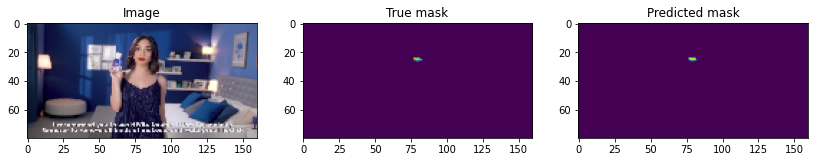

25000it [11:37:58,  2.86it/s]

[25000] Loss: 0.002812867984175682


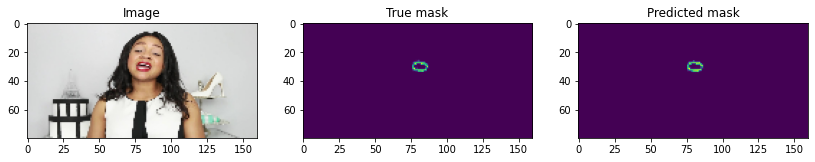

25500it [11:40:59,  2.86it/s]

[25500] Loss: 0.006680636201053858


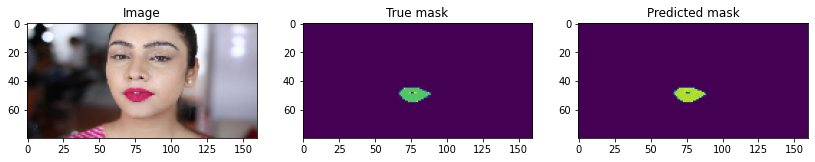

26000it [11:43:59,  2.76it/s]

[26000] Loss: 0.002160424366593361


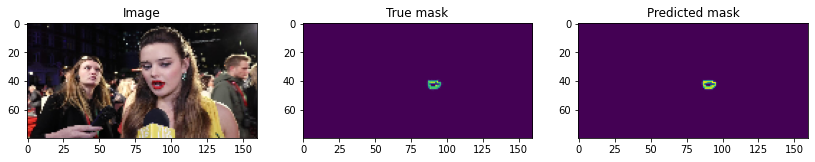

26500it [11:47:01,  2.86it/s]

[26500] Loss: 0.004727938678115606


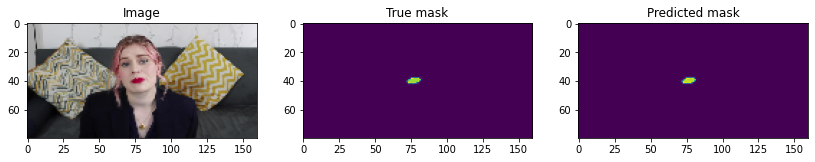

27000it [11:50:02,  2.86it/s]

[27000] Loss: 0.019802574068307877


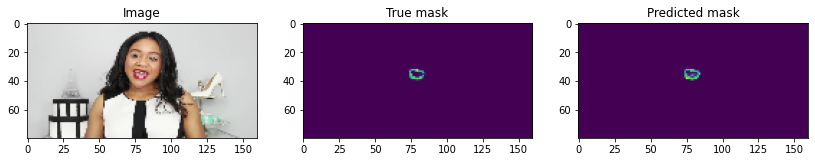

27500it [11:53:03,  2.83it/s]

[27500] Loss: 0.0023849194403737783


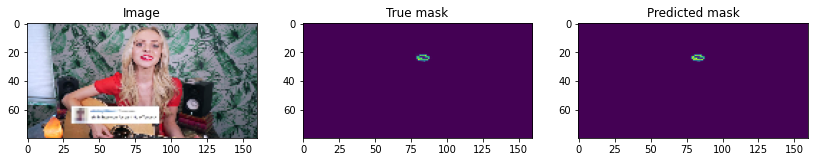

28000it [11:56:05,  2.81it/s]

[28000] Loss: 0.0035900077782571316


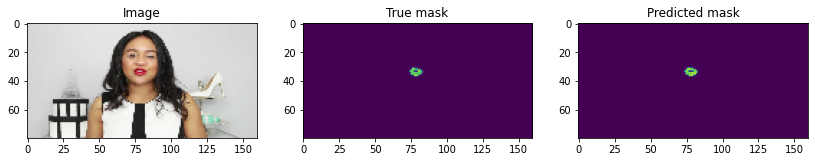

28500it [11:59:06,  2.87it/s]

[28500] Loss: 0.004020707216113806


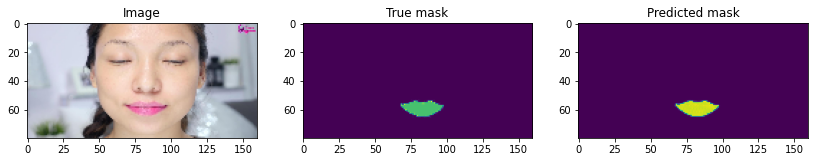

29000it [12:02:09,  2.80it/s]

[29000] Loss: 0.0018315353663638234


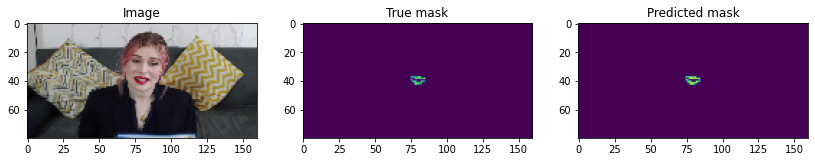

29500it [12:05:12,  2.84it/s]

[29500] Loss: 0.008133942261338234


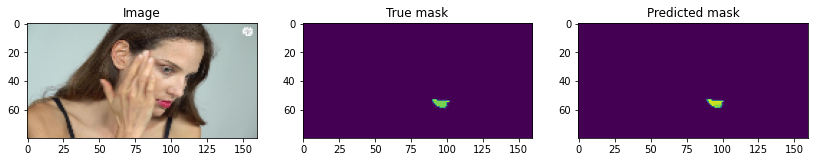

30000it [12:08:14,  2.80it/s]

[30000] Loss: 0.0033777791541069746


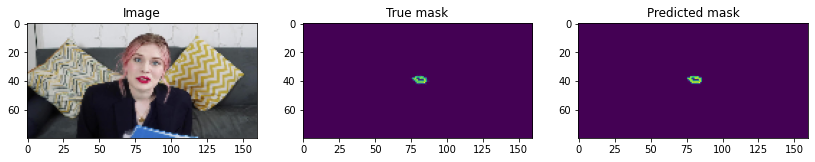

30500it [12:11:17,  2.70it/s]

[30500] Loss: 0.0036326665431261063


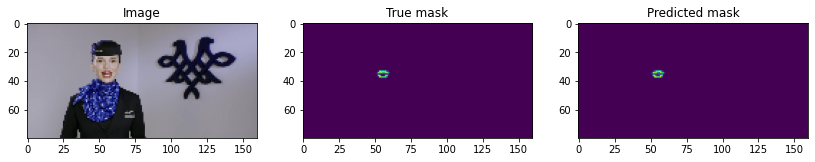

31000it [12:14:21,  2.76it/s]

[31000] Loss: 0.003260999917984009


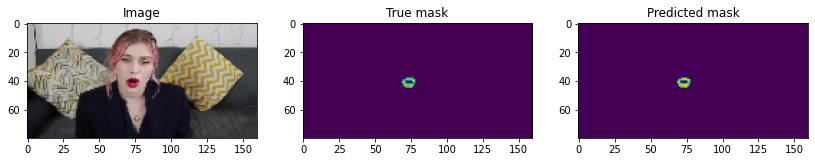

31500it [12:17:24,  2.82it/s]

[31500] Loss: 0.0022892591077834368


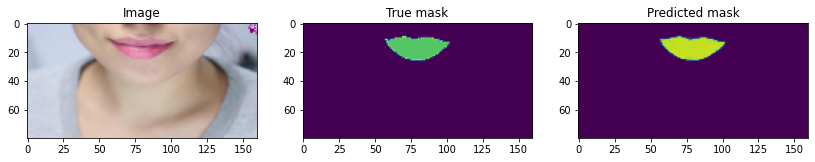

32000it [12:20:28,  2.78it/s]

[32000] Loss: 0.0023624065797775984


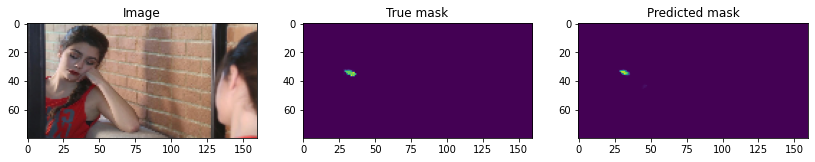

32500it [12:23:32,  2.80it/s]

[32500] Loss: 0.00596949877217412


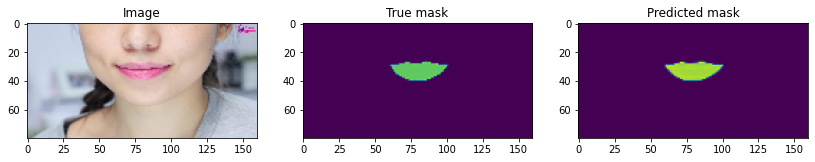

33000it [12:26:34,  2.80it/s]

[33000] Loss: 0.006092059426009655


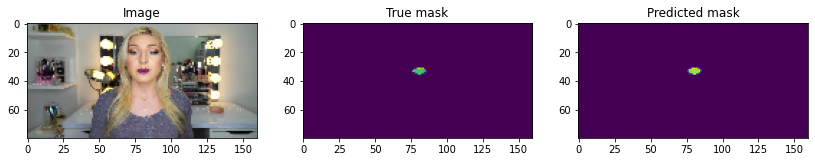

33500it [12:29:35,  2.82it/s]

[33500] Loss: 0.0024042087607085705


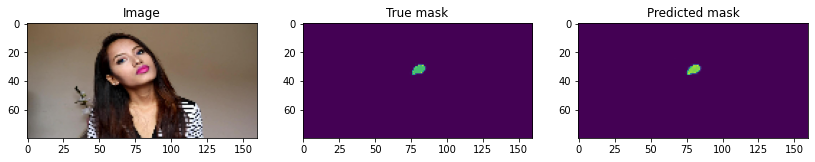

34000it [12:32:37,  2.84it/s]

[34000] Loss: 0.0045412261970341206


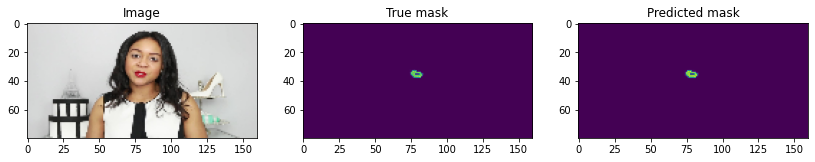

34500it [12:35:38,  2.81it/s]

[34500] Loss: 0.0048402282409369946


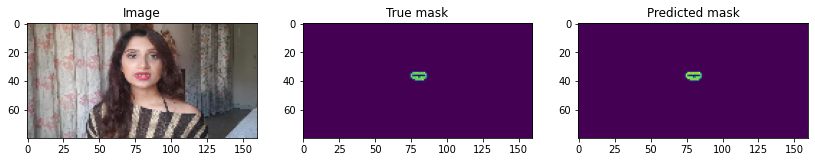

35000it [12:38:42,  2.79it/s]

[35000] Loss: 0.003249164903536439


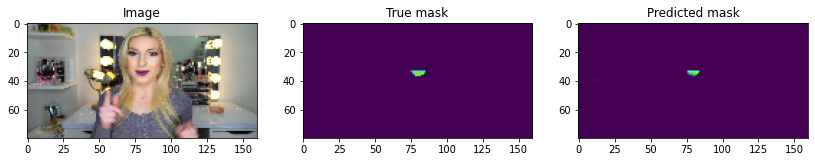

35500it [12:41:43,  2.79it/s]

[35500] Loss: 0.0073557887226343155


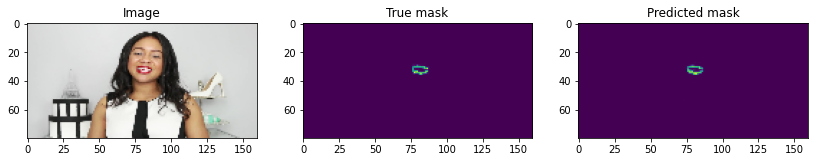

35675it [12:42:49,  1.28s/it]

Wall time: 12h 42min 54s


In [19]:
%%time
for iteration, (images, labels) in tqdm(enumerate(train_ds)):
    with tf.GradientTape() as tape:
        segmentation = model(images)
        loss_value = sigmoid_cross_entropy(y_true=labels, y_pred=segmentation)
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    
    if iteration % 500 == 0:
        print(f'[{iteration}] Loss: {loss_value.numpy()}')
        plt.figure(figsize=(14, 5))
        plt.subplot(131)
        plt.title('Image')
        plt.imshow(images[0])
        plt.subplot(132)
        plt.title('True mask')
        plt.imshow(labels[0])
        plt.subplot(133)
        plt.title('Predicted mask')
        plt.imshow(model(images)[0])
        plt.show()

## Test check

In [24]:
X_test = []
with tf.device('/CPU:0'):
    for image_path in glob.glob("./set-lipstick-original/720p/*.jpg"):
        # leave only pics with mask
        if np.any(np.isin(data_test['filename'], image_path[-17:])):
            img = imageio.imread(image_path).astype(np.float32) / 255.
            X_test.append(tf.image.resize(img, size=(80, 160)))
    print(np.array(X_test).shape)

(54, 80, 160, 3)


In [39]:
test_ds = tf.data.Dataset.from_tensor_slices(X_test)
test_ds = test_ds.batch(BATCH_SIZE)
print(test_ds)

<BatchDataset shapes: (None, 80, 160, 3), types: tf.float32>


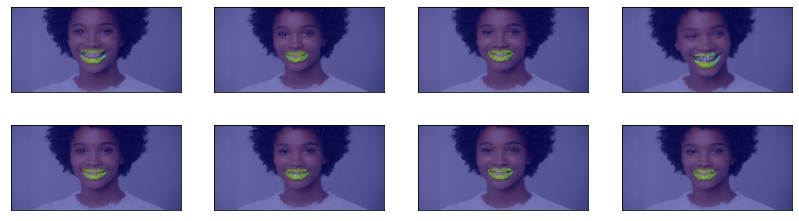

In [94]:
num = 1
fig = plt.figure(figsize=(14, num*2 +2))
samples = [x for x in iter(test_ds.take(num))]
k = 0
for i in range(num):
    for j in range(BATCH_SIZE):
        out = model.predict(samples[i])[j]
        seg_map = out.astype(np.float32)
        seg_map_clr = plt.get_cmap('gist_ncar')(seg_map)[..., :3]
        k += 1
        ax = fig.add_subplot(2*num, 4, k)
        ax.imshow(samples[i][j]*0.5 + seg_map_clr[..., 0, :]*0.5)
        plt.xticks([]), plt.yticks([])
plt.show()